## Step 1 - Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import glob
import xml.etree.ElementTree as ET
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing


In [9]:
class RNASequences:
    def __init__(self, data_dir="Data/"):
        filenames = glob.glob("*.txt", root_dir=data_dir)
        dfs = []

        for filename in filenames:
            df = pd.read_csv(data_dir + filename, sep="\t", names=[filename[:10]], skiprows=1).T
            dfs.append(df)
        
        self.__rna_counts = pd.concat(dfs)

        self.__annotations = pd.DataFrame(columns=("Subject ID", "Sample Group", "CNS Subregion"))
        tree = ET.parse(open("Data/GSE124439_family.xml"))
        root = tree.getroot()
        namespace = {"ns": "http://www.ncbi.nlm.nih.gov/geo/info/MINiML"}

        for sample in root.findall("ns:Sample", namespace):
            sample_id = sample.attrib["iid"]
            for channel in sample.iterfind(".//ns:Channel", namespace):
                self.__annotations.loc[sample_id] = [
                    channel[4].text.strip(),
                    channel[5].text.strip(),
                    channel[3].text.strip(),
                ]
        
        self.__annotations = self.__annotations
        self.__check_annotations()
    

    def __check_annotations(self):
        assert self.__rna_counts.index.difference(self.__annotations.index).empty


    def _ipython_display_(self):
        display(self.__rna_counts)
        display(self.__annotations)


    def get_counts(self):
        return self.__rna_counts
    

    def get_annotations(self):
        return self.__annotations
    
    def get_samples(self):
        return self.get_sample_count("ALS"), self.get_sample_count("Control"), self.get_sample_count("Other")


    def get_count(self, item):
        if isinstance(item, str):
            return self.__rna_counts[item]
        else:
            return self.__rna_counts.at[item[0], item[1]]
    

    def get_annotation(self, item):
        if isinstance(item, str):
            return self.__annotations[item]
        else:
            return self.__annotations.at[item[0], item[1]]
        

    def get_sample(self, sample=None):
        match sample:
            case "ALS":
                return self.__annotations.loc[self.__annotations["Sample Group"] == "ALS Spectrum MND"]
            case "Control":
                return self.__annotations.loc[self.__annotations["Sample Group"] == "Non-Neurological Control"]
            case "Other":
                return self.__annotations.loc[self.__annotations["Sample Group"] == "Other Neurological Disorders"]
            case _:
                return self.__annotations
            
    
    def get_sample_count(self, sample=None):
        return self.__rna_counts.loc[self.get_sample(sample).index]


    def mean(self, sample=None, rename=True):
        if rename:
            return self.get_sample_count(sample).mean().to_frame().rename(columns={0: "Means"})
        else:
            return self.get_sample_count(sample).mean().to_frame()
    

    def median(self, sample=None, rename=True):
        if rename:
            return self.get_sample_count(sample).median().to_frame().rename(columns={0: "Medians"})
        else:
            return self.get_sample_count(sample).median().to_frame()
    

    def std(self, sample=None, rename=True):
        if rename:
            return self.get_sample_count(sample).std().to_frame().rename(columns={0: "Standard Deviations"})
        else:
            return self.get_sample_count(sample).std().to_frame()
    

df = RNASequences()
df

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
GSM3533382,42,189,0,4052,92,201,1,8,76,1,...,1023,2363,2137,1265,100,607,140,551,2269,2233
GSM3533252,37,110,0,4660,102,64,7,1,68,0,...,880,2077,1908,1072,119,478,129,525,1821,1921
GSM3533337,31,110,0,1484,84,60,1,1,12,0,...,656,1357,1345,749,61,341,102,346,1122,1437
GSM3533314,14,41,0,2185,105,198,4,0,24,0,...,958,2017,1817,1087,99,527,145,446,1522,1757
GSM3533391,37,118,0,1245,104,168,1,1,21,1,...,847,1822,1625,903,96,472,120,415,1556,1768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3533291,29,142,0,1429,102,115,2,4,14,1,...,671,1526,1319,735,85,394,92,330,1279,1408
GSM3533349,31,142,0,1526,108,122,2,1,139,0,...,758,1724,1575,866,76,427,122,430,1478,1660
GSM3533339,39,95,0,1223,74,89,1,3,39,0,...,687,1424,1340,693,101,354,83,300,1145,1390
GSM3533399,46,179,0,2899,89,109,1,6,46,1,...,796,1694,1488,869,89,469,99,442,1684,1836


,Subject ID,Sample Group,CNS Subregion
GSM3533230,NEUEL133AK6,ALS Spectrum MND,Frontal Cortex
GSM3533231,NEUYV496XLP,ALS Spectrum MND,Frontal Cortex
GSM3533232,NEUZU200WEQ,ALS Spectrum MND,Frontal Cortex
GSM3533233,NEUME287RK2,ALS Spectrum MND,Frontal Cortex
GSM3533234,NEUEC006FND,ALS Spectrum MND,Frontal Cortex
...,...,...,...
GSM3533401,NEUMY028JH4,ALS Spectrum MND,Frontal Cortex
GSM3533402,NEUXR145UBL,ALS Spectrum MND,Frontal Cortex
GSM3533403,NEUKN209FNW,ALS Spectrum MND,Frontal Cortex
GSM3533404,NEUUF289NRL,ALS Spectrum MND,Frontal Cortex


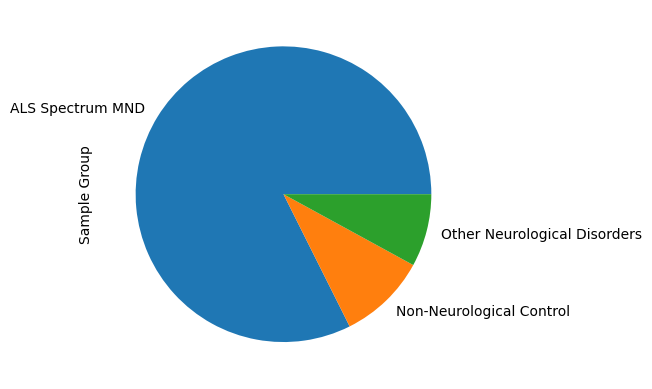

In [10]:
sample_groups = df.get_annotations()

sample_groups["Sample Group"].value_counts().plot(kind="pie")
plt.show()

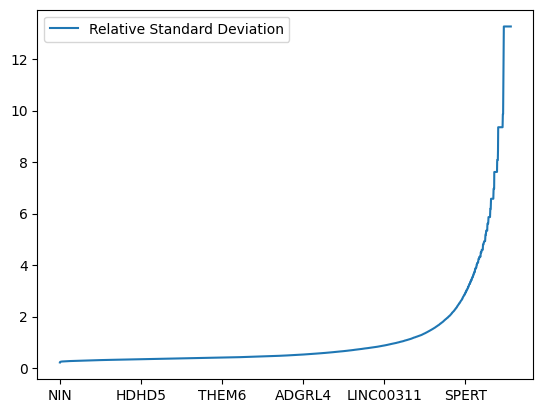

In [11]:
means = df.mean(rename=False)
stds = df.std(rename=False)
means = means[means[0] != 0]
stds = stds[stds[0] != 0]
rsd = stds.div(means).sort_values(by=0).rename(columns={0: "Relative Standard Deviation"}).plot()
plt.show()

In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(df.get_counts())

scaled_data = preprocessing.scale(df.get_counts())
pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

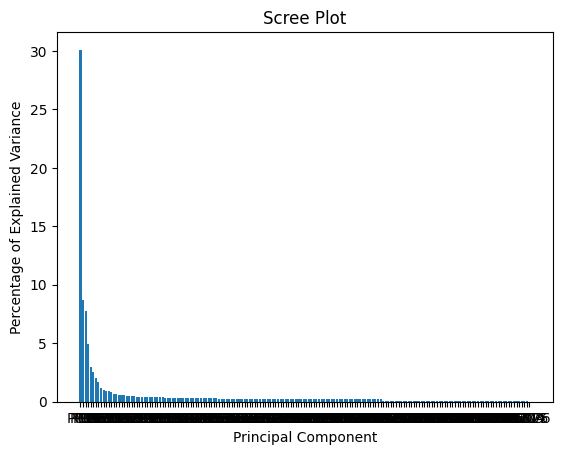

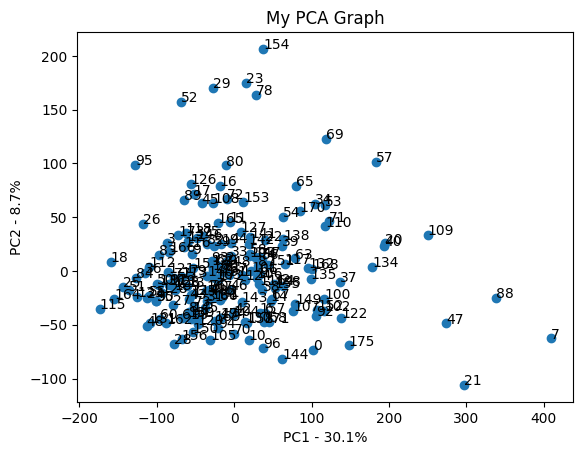

In [18]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()
 
#the following code makes a fancy looking plot using PC1 and PC2
pca_df = pd.DataFrame(pca_data, columns=labels)
 
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('My PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
 
for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
 
plt.show()

In [20]:
loading_scores = pd.Series(pca.components_[0])
## now sort the loading scores based on their magnitude
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
 
# get the names of the top 10 genes
top_10_genes = sorted_loading_scores[0:10].index.values
 
## print the gene names and their scores (and +/- sign)
print(loading_scores[top_10_genes])

6045     0.010539
21511    0.010487
24364    0.010480
3484     0.010476
26534    0.010475
4641     0.010462
17139    0.010454
17863    0.010444
20373    0.010437
20998    0.010432
dtype: float64
